In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def add_basic_stats(row, moves, pref=""):

    row[pref + 'winrate_mean'] = np.mean(moves.winrate_delta)
    row[pref + 'score_mean'] = np.mean(moves.score_delta)
    row[pref + 'score_var'] = np.var(moves.score_delta)
    row[pref + 'selfplay_mean'] = np.mean(moves.selfplay_delta)
    row[pref + 'utility_mean'] = np.mean(moves.utility_delta)
    row[pref + 'winrate_beauty_percent'] = np.mean([x > 0 for x in moves.winrate_delta])
    row[pref + 'score_beauty_percent'] = np.mean([x > 0 for x in moves.score_delta])


def add_advanced_stats(row, moves, pref=""):
    moves.score_delta.sort()
    moves.winrate_delta.sort()

    row[pref + 'score25p'] = moves.score_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'score75p'] = moves.score_delta[int(moves.cnt_moves * 0.75)]
    row[pref + 'score_max'] = np.max(moves.score_delta)
    row[pref + 'score_min'] = np.min(moves.score_delta)
    row[pref + 'winrate25p'] = moves.winrate_delta[int(moves.cnt_moves * 0.25)]
    row[pref + 'winrate75p'] = moves.winrate_delta[int(moves.cnt_moves * 0.75)]

    row[pref + 'score_five_best_mean'] = np.mean(moves.score_delta[-5:])
    row[pref + 'score_five_worst_mean'] = np.mean(moves.score_delta[:5])

    row[pref + 'stddev_last'] = moves.stddev_delta[-1]
    moves.stddev_delta.sort()
    row[pref + 'stddev_mean'] = np.mean(moves.stddev_delta)
    row[pref + 'stddev50p'] = moves.stddev_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'score50p'] = moves.score_delta[int(moves.cnt_moves * 0.5)]

    row[pref + 'winrate_midmean'] = np.mean(
        moves.winrate_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])
    row[pref + 'score_midmean'] = np.mean(moves.score_delta[int(moves.cnt_moves * 0.25):int(moves.cnt_moves * 0.75)])


def get_index_dan(rank):
  for i in range(len(rank)):
    if rank[i] in ['k', 'd']:
      return i
  return -1


def get_int_from_rank(rank):
    ind = get_index_dan(rank)
    if ind < 0 or rank[0] == 'P' or not rank[:ind].isdigit():
        return None
    if rank[ind] == 'k':
        return -int(rank[:ind]) + 1
    else:
        return int(rank[:ind])


def get_rank_from_int(x):
    if x > 0:
        return str(x) + "d"
    else:
        return str(-x + 1) + "k"


def int_from_player(player):
    return int(player == 'W')


def player_from_int(x):
    return 'W' if x == 1 else 'B'


def add_meta(row, player='W'):
    if row['Result'] == '?':
        row['game_result'] = 0
    else:
        row['game_result'] = int(row['Result'])
        if player == 'B':
            row['game_result'] = -row['game_result']
    row['color'] = int_from_player(player)
    row['rank'] = get_int_from_rank(row[player + '_rating'])
    row['game_length'] = len(row['W_move']) + len(row['B_move'])


def convert_to_lists(df):
    for i, row in tqdm(df.iterrows()):
        row['kek'] = i
        row['W_scoreLead'] = [float(x) for x in row['W_scoreLead'].split()]
        row['B_scoreLead'] = [float(x) for x in row['B_scoreLead'].split()]
        row['W_scoreSelfplay'] = [float(x) for x in row['W_scoreSelfplay'].split()]
        row['B_scoreSelfplay'] = [float(x) for x in row['B_scoreSelfplay'].split()]
        row['W_scoreStdev'] = [float(x) for x in row['W_scoreStdev'].split()]
        row['B_scoreStdev'] = [float(x) for x in row['B_scoreStdev'].split()]
        row['W_utility'] = [float(x) for x in row['W_utility'].split()]
        row['B_utility'] = [float(x) for x in row['B_utility'].split()]
        row['W_winrate'] = [float(x) for x in row['W_winrate'].split()]
        row['B_winrate'] = [float(x) for x in row['B_winrate'].split()]
        df.loc[i] = row

class MovesInfo:
    def __init__(self, row, n_moves=None, player='W'):
        enemy = 'B' if player == 'W' else 'W'
        if player == 'B':
            moves_len = min(len(row['B_winrate']), len(row['W_winrate']) + 1)
        else:
            moves_len = min(len(row['W_winrate']), len(row['B_winrate']))

        if n_moves is None:
            start_ind = 0
        else:
            start_ind = max(moves_len - n_moves - 1, 0)

        end_ind = moves_len
        w_0 = []
        sc_0 = []
        ut_0 = []
        std_0 = []
        sf_0 = []
        if player == 'B':
            if start_ind == 0:
                w_0 = [0.475]
                sc_0 = [0.]
                ut_0 = [0.]
                std_0 = [19. - 0.07666535852999867 * 2]
                sf_0 = [0.]
            else:
                w_0 = [row[enemy + '_winrate'][start_ind - 1]]

                sc_0 = [row[enemy + '_scoreLead'][start_ind - 1]]
                ut_0 = [row[enemy + '_utility'][start_ind - 1]]
                std_0 = [row[enemy + '_scoreStdev'][start_ind - 1]]
                sf_0 = [row[enemy + '_scoreSelfplay'][start_ind - 1]]
        self.winrate_delta = np.array(row[player + '_winrate'][start_ind:end_ind]) - np.array(
            (w_0 + row[enemy + '_winrate'])[start_ind:end_ind])
        self.score_delta = np.array(row[player + '_scoreLead'][start_ind:end_ind]) - np.array(
            (sc_0 + row[enemy + '_scoreLead'])[start_ind:end_ind])
        self.utility_delta = np.array(row[player + '_utility'][start_ind:end_ind]) - np.array(
            (ut_0 + row[enemy + '_utility'])[start_ind:end_ind])
        self.selfplay_delta = np.array(row[player + '_scoreSelfplay'][start_ind:end_ind]) - np.array(
            (sf_0 + row[enemy + '_scoreSelfplay'])[start_ind:end_ind])
        self.stddev_delta = np.array(row[player + '_scoreStdev'][start_ind:end_ind]) - np.array(
            (std_0 + row[enemy + '_scoreStdev'])[start_ind:end_ind])

        if player == 'B':
            self.winrate_delta = -self.winrate_delta
            self.score_delta = -self.score_delta
            self.utility_delta = -self.utility_delta
            self.selfplay_delta = -self.selfplay_delta

        self.move = row[player + '_move'].split()
        self.cnt_moves = end_ind - start_ind


def add_all_game_stats(df, player = 'W'):
    df['winrate_mean'] = None
    df['score_midmean'] = None
    df['score_mean'] = None
    df['score_var'] = None
    df['winrate_beauty_percent'] = None
    df['score_beauty_percent'] = None
    df['utility_mean'] = None
    df['score25p'] = None
    df['score75p'] = None
    df['winrate25p'] = None
    df['winrate75p'] = None
    df['winrate_midmean'] = None
    df['score50p'] = None
    df['game_length'] = None
    df['rank'] = None
    df['color'] = None
    df['game_result'] = None
    df['selfplay_mean'] = None
    df['stddev_mean'] = None
    df['stddev50p'] = None
    df['stddev_last'] = None
    df['score_max'] = None
    df['score_min'] = None
    df['score_five_best_mean'] = None
    df['score_five_worst_mean'] = None

    for i, row in tqdm(df.iterrows()):
        add_meta(row, player=player)
        add_basic_stats(row, MovesInfo(row, player=player))
        add_advanced_stats(row, MovesInfo(row, player=player))
        df.loc[i] = row


def get_start_of_yose(margin_moves, no_change_count=5):
    '''
    Находим сколько последних ходов мы будем считать что это йосе

    Будем идти с конца по массиву количества ходов на краю, если в массиве no_change_count одинаковых чисел,
    то мы останавливаемся и говорим, что тут началось йосе
    '''
    no_change = 1
    ans = len(margin_moves)
    for i in range(len(margin_moves) - 2, -1, -1):
        if margin_moves[i] == margin_moves[i + 1]:
            no_change += 1
        else:
            no_change = 1
        if no_change >= no_change_count:
            ans = len(margin_moves) - i - 1
            break
    return ans


def reset_basic_stats(df, pref):
    df[pref + 'winrate_mean'] = None
    df[pref + 'winrate_beauty_percent'] = None
    df[pref + 'score_beauty_percent'] = None
    df[pref + 'score_mean'] = None
    df[pref + 'selfplay_mean'] = None
    df[pref + 'score_var'] = None
    df[pref + 'utility_mean'] = None


def is_marginal_move(move):
    return (move[0] == 'a' or move[0] == 'b') or (move[0] == 'r' or move[0] == 's') or \
           (move[1] == 'a' or move[1] == 'b') or (move[1] == 'r' or move[1] == 's')


def count_of_marginal_moves(moves):
    ans = np.zeros(len(moves))
    for i in range(len(moves)):
        ans[i] = is_marginal_move(moves[i])
    ans = np.cumsum(ans)
    return ans


def add_yose_stats(df, player = 'W'):
    pref = 'yose_'
    reset_basic_stats(df, pref)
    df['yose_length'] = None
    df['yose_start'] = None
    df['yose_has'] = None
    for i, row in tqdm(df.iterrows()):
        marginal_moves = count_of_marginal_moves(row['W_move'].split())
        n_moves = get_start_of_yose(marginal_moves, 10)
        add_basic_stats(row, MovesInfo(row, n_moves, player=player), pref)
        row['yose_length'] = n_moves
        row['yose_start'] = len(row['W_move'].split()) - n_moves
        row['yose_has'] = row['yose_start'] != 0
        df.loc[i] = row


def delta_moves(a, b):
    return abs(ord(a[0]) - ord(b[0])) + abs(ord(a[1]) - ord(b[1]))


def get_distance_of_moves(moves):
    ans = np.zeros(len(moves) - 1)
    for i in range(1, len(moves)):
        ans[i - 1] = delta_moves(moves[i], moves[i - 1])
    return ans


def get_distance_from_enemy(my_moves, enemy_moves):
    ans = np.zeros(min(len(my_moves), len(enemy_moves)))
    for i in range(min(len(my_moves), len(enemy_moves))):
        ans[i] = delta_moves(my_moves[i], enemy_moves[i])
    return ans


def add_last_moves_stats(df, n_moves, pref=None, player='W'):
    if pref is None:
        pref = str(n_moves) + "_"
    reset_basic_stats(df, pref)
    for i, row in tqdm(df.iterrows()):
        add_basic_stats(row, MovesInfo(row, n_moves, player=player), pref)
        df.loc[i] = row


def add_dist_stats_to_row(row, player='W'):
    enemy = 'W' if player == 'B' else 'W'
    dist = get_distance_of_moves(row[player+'_move'].split())
    dist_enemy = get_distance_from_enemy(row[player + '_move'].split(), row[enemy + '_move'].split())
    dist.sort()

    row['dist_mean'] = np.mean(dist)
    row['dist_var'] = np.var(dist)
    row['dist_median'] = dist[len(dist) // 2]
    row['dist_percent_more_than_10'] = np.mean([x > 10 for x in dist])
    row['dist_percent_more_than_5'] = np.mean([x > 5 for x in dist])
    row['dist_percent_more_than_20'] = np.mean([x > 20 for x in dist])

    row['dist_from_enemy_mean'] = np.mean(dist_enemy)
    row['dist_from_enemy_var'] = np.var(dist_enemy)


def add_dist_stats(df, player='W'):
    df['dist_mean'] = None
    df['dist_var'] = None
    df['dist_median'] = None
    df['dist_percent_more_than_5'] = None
    df['dist_percent_more_than_10'] = None
    df['dist_percent_more_than_20'] = None

    df['dist_from_enemy_mean'] = None
    df['dist_from_enemy_var'] = None

    for i, row in tqdm(df.iterrows()):
       if len(row['W_move']) > 20:
        add_dist_stats_to_row(row, player=player)
        df.loc[i] = row


def delete_non_scalar_parameters(df):
    df.drop(['W_rating', 'B_rating', 'W_move', 'B_move', 'W_scoreLead', 'B_scoreLead', 'W_scoreSelfplay',
             'B_scoreSelfplay', 'W_scoreStdev', 'B_scoreStdev', 'W_utility', 'B_utility',
             'W_winrate', 'B_winrate', 'Result'], axis=1, inplace=True)


def add_delta_lists_to_row(row, moves, player = 'W'):
    row['winrate'] = moves.winrate_delta
    row['score'] = moves.score_delta
    row['winrate_sqr'] = np.array([x ** 2 for x  in moves.winrate_delta])
    row['score_sqr'] = np.array([x ** 2 for x  in moves.score_delta])
    row['utility'] = moves.utility_delta
    row['selfplay'] = moves.selfplay_delta
    row['stddev'] = moves.stddev_delta
    row['dist_from_prev'] = get_distance_of_moves(moves.move)
    row['dist_more_5'] = [int(x > 5) + 1 for x in row['dist_from_prev']]
    enemy = 'B' if player == 'W' else 'W'
    row['dist_enemy'] = get_distance_from_enemy(row[player + '_move'].split(), row[enemy + '_move'].split())


def add_lists_to_df(df, player='W'):
    df['winrate'] = None
    df['score'] = None
    df['utility'] = None
    df['selfplay'] = None
    df['stddev'] = None
    df['dist_from_prev'] = None
    df['rank'] = None
    df['color'] = None
    df['game_length'] = None
    df['score_sqr'] = None
    df['winrate_sqr'] = None
    df['dist_more_5'] = None
    df['dist_enemy'] = None
    for i, row in tqdm(df.iterrows()):
        add_meta(row, player)
        add_delta_lists_to_row(row, MovesInfo(row, player=player))
        df.loc[i] = row


def get_feature_df(df, player='W'):
    convert_to_lists(df)
    add_all_game_stats(df, player)
    add_yose_stats(df, player)
    add_last_moves_stats(df, 10, player)
    add_last_moves_stats(df, 20, player)
    add_dist_stats(df, player)
    delete_non_scalar_parameters(df)
    return df

def add_meta_to_df(df, player='W'):
    df['rank'] = None
    df['color'] = None
    df['game_length'] = None
    for i, row in tqdm(df.iterrows()):
        try:
            add_meta(row, player)
            df.loc[i] = row
        except Exception as e:
            print(e)
            df = df.drop(index=[i])

def get_df_with_lists(df, player='W'):
    add_meta_to_df(df, player)
    df = df[df['game_length'] >= 40]
    convert_to_lists(df)
    add_all_game_stats(df, player)
    #add_last_moves_stats(df, 20, player = player)
    #add_dist_stats(df, player)
    add_lists_to_df(df, player)
    #delete_non_scalar_parameters(df)
    return df


In [2]:
from google.colab import drive
drive.mount('/content/drive')
katago = pd.read_csv('/content/drive/MyDrive/GO_dataset_after_script/15k-9d/data.csv')[-80000:]
katago.dropna(how = 'any', inplace= True)

Mounted at /content/drive


In [3]:
katago.dropna(how = 'any', inplace= True)

In [4]:
import warnings 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    katago_white = get_df_with_lists(katago, player = 'W')

79658it [02:12, 599.82it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
79615it [02:36, 509.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [5]:
katago_all = katago_white
katago_all.dropna(how='any', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [6]:
features = ['score', 'winrate', 'utility', 'stddev', 'selfplay', 'dist_from_prev', 
            'W_winrate', 'B_winrate', 'W_scoreLead', 'B_scoreLead', 'W_scoreSelfplay',
             'B_scoreSelfplay', 'W_scoreStdev', 'B_scoreStdev', 'dist_enemy']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(katago_all[features], katago_all['rank'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

def get_tensor(df, features, sequence_len):
    def resize_to_length(m, length):
        if len(m) > length:
            return m[:length]
        n_nules = length - len(m)
        return list([0] * n_nules) + list(m)

    arr = []
    for feature in features:
        arr.append([np.array(y) for y in df[feature].apply(lambda x: resize_to_length(x, sequence_len))])
    arr = np.array(arr)
    arr = arr.swapaxes(0, 1)
    arr = arr.swapaxes(1, 2)
    return tf.convert_to_tensor(arr, np.float32)


class RnnKerasRunner:
    __DEFAULT_FEATURES = ['score', 'winrate', 'utility', 'stddev', 'selfplay', 'dist_from_prev', 'winrate_sqr', 'score_sqr', 'dist_more_5']

    def __create_rnn(self, hidden_units, input_shape):
        model = keras.Sequential()
        model.add(tf.keras.layers.Masking(mask_value=0.,
                                          input_shape=input_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units=12, activation="linear"))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Bidirectional(layers.LSTM(hidden_units)))  
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(units=1, activation="linear"))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics="mean_absolute_error")
        return model

    def __init__(self, model = None, sequence_len=150, features=__DEFAULT_FEATURES):
        self.features = features
        self.sequence_len = sequence_len
        if model is None:
            self.model = self.__create_rnn(128, (sequence_len, len(features)))
        else:
            self.model = model

    def fit(self, df, target, val_X, val_y, epochs=10, batch_size=256):
        val_data = None
        if val_X is not None:
            val_X = get_tensor(val_X, self.features, self.sequence_len)
            val_y = tf.convert_to_tensor(val_y, np.float32)
            val_data = (val_X, val_y)
        X = get_tensor(df, self.features, self.sequence_len)
        self.model.fit(X, tf.convert_to_tensor(target, np.float32), validation_data = val_data, epochs=epochs,
                       batch_size=batch_size)


    def predict(self, df):
        X = get_tensor(df, self.features, self.sequence_len)
        return np.array([y[0] for y in self.model.predict(X)])

In [39]:
model = RnnKerasRunner(sequence_len=150, features = features)

In [40]:
model.fit(X_train, y_train, X_val, y_val, epochs=12, batch_size=1024)

Epoch 1/12
53/53 [==============================] - 73s 1s/step - loss: 29.8820 - mean_absolute_error: 4.5595 - val_loss: 32.4399 - val_mean_absolute_error: 4.4958
Epoch 2/12
53/53 [==============================] - 59s 1s/step - loss: 16.8103 - mean_absolute_error: 3.2233 - val_loss: 35.2151 - val_mean_absolute_error: 4.6819
Epoch 3/12
53/53 [==============================] - 57s 1s/step - loss: 15.3414 - mean_absolute_error: 3.0458 - val_loss: 36.3510 - val_mean_absolute_error: 4.8027
Epoch 4/12
53/53 [==============================] - 57s 1s/step - loss: 14.8904 - mean_absolute_error: 2.9889 - val_loss: 31.2003 - val_mean_absolute_error: 4.4038
Epoch 5/12
53/53 [==============================] - 57s 1s/step - loss: 14.4451 - mean_absolute_error: 2.9297 - val_loss: 23.6433 - val_mean_absolute_error: 3.7688
Epoch 6/12
53/53 [==============================] - 57s 1s/step - loss: 14.4526 - mean_absolute_error: 2.9303 - val_loss: 21.9071 - val_mean_absolute_error: 3.6132
Epoch 7/12
53/53

In [41]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

2.796250193738043


In [43]:
model.model.save('/content/drive/MyDrive/rnn_april_23_lstm.h5')

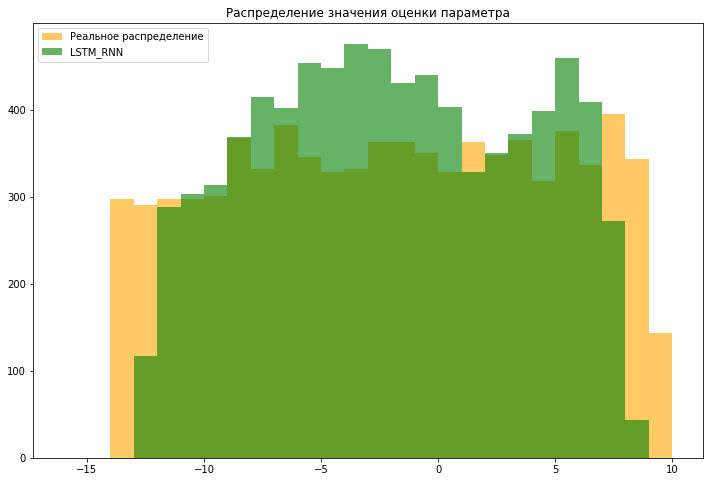

In [61]:
from matplotlib import pyplot as plt
plt_bins = [i + -16.001 for i in range(27)]
plt.figure(figsize=(12, 8))
plt.title("Распределение значения оценки параметра")
plt.hist(
    y_test,
    bins = plt_bins,
    alpha = 0.6,
    color = 'orange',
    label = 'Реальное распределение'
)
plt.hist(
    y_pred,
    bins = plt_bins,
    alpha = 0.6,
    color = 'green',
    label = 'LSTM_RNN'
)
plt.legend()
plt.show()

# GRU

In [121]:
class GRUKerasRunner(RnnKerasRunner):
    def __create_rnn(self, hidden_units, input_shape):
        model = keras.Sequential()
        model.add(tf.keras.layers.Masking(mask_value=0.,
                                          input_shape=input_shape))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units=12, activation="linear"))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Bidirectional(layers.GRU(hidden_units)))  
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(units=1, activation="linear"))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics="mean_absolute_error")
        return model

In [122]:
model_gru = GRUKerasRunner(sequence_len=150, features = features)

In [124]:
model_gru.fit(X_train, y_train, X_val, y_val, epochs=8, batch_size=2048)

Epoch 1/8
27/27 [==============================] - 35s 1s/step - loss: 16.6618 - mean_absolute_error: 3.2291 - val_loss: 70.6241 - val_mean_absolute_error: 6.8812
Epoch 2/8
27/27 [==============================] - 35s 1s/step - loss: 15.0933 - mean_absolute_error: 3.0260 - val_loss: 71.3790 - val_mean_absolute_error: 7.0203
Epoch 3/8
27/27 [==============================] - 34s 1s/step - loss: 15.0318 - mean_absolute_error: 3.0051 - val_loss: 49.6050 - val_mean_absolute_error: 5.7524
Epoch 4/8
27/27 [==============================] - 34s 1s/step - loss: 15.3194 - mean_absolute_error: 3.0453 - val_loss: 51.8726 - val_mean_absolute_error: 5.9109
Epoch 5/8
27/27 [==============================] - 34s 1s/step - loss: 14.5465 - mean_absolute_error: 2.9519 - val_loss: 42.5725 - val_mean_absolute_error: 5.2861
Epoch 6/8
27/27 [==============================] - 34s 1s/step - loss: 14.4139 - mean_absolute_error: 2.9309 - val_loss: 33.3394 - val_mean_absolute_error: 4.5857
Epoch 7/8
27/27 [=====

In [128]:
y_pred_gru = model_gru.predict(X_test)
print(mean_absolute_error(y_test, y_pred_gru))

4.350355798921098


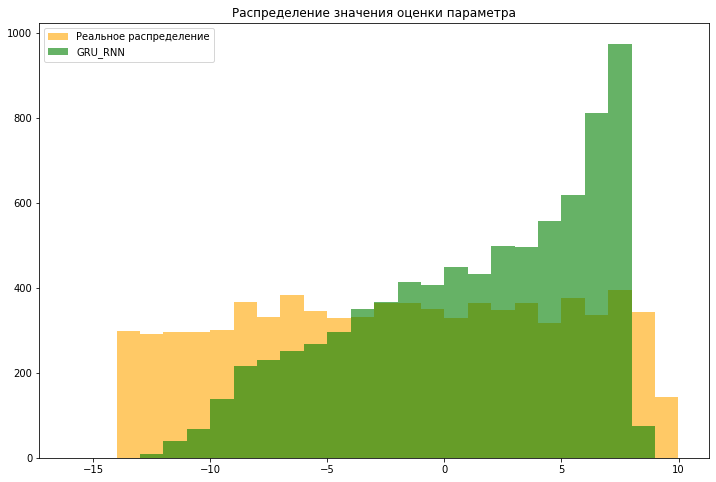

In [129]:
from matplotlib import pyplot as plt
plt_bins = [i + -16.001 for i in range(27)]
plt.figure(figsize=(12, 8))
plt.title("Распределение значения оценки параметра")
plt.hist(
    y_test,
    bins = plt_bins,
    alpha = 0.6,
    color = 'orange',
    label = 'Реальное распределение'
)
plt.hist(
    y_pred_gru,
    bins = plt_bins,
    alpha = 0.6,
    color = 'green',
    label = 'GRU_RNN'
)
plt.legend()
plt.show()

In [127]:
model.model.save('/content/drive/MyDrive/rnn_april_23_gru.h5')

# Submodels experiments

In [142]:
bins = np.array([-11.5, 10])
submodels_amount = 2
borders = ((-14, -11), (-10, 9))
y_train_big = np.digitize(y_train, bins)
y_test_big = np.digitize(y_test, bins)

In [143]:
train_idx = []

for left, right in borders:
    train_idx.append(y_train.index[(y_train >= left) & (y_train <= right)])

submodels_X_train = []
submodels_y_train = []
sum_len = 0
for idx in train_idx:
    sum_len += len(y_train.loc[idx])
    submodels_X_train.append(X_train.loc[idx])
    submodels_y_train.append(y_train.loc[idx])

In [144]:
class SubRnnKerasRunner(RnnKerasRunner):
    def fit(self, df, target, epochs=10, batch_size=256):
        X = get_tensor(df, self.features, self.sequence_len)
        self.model.fit(X, tf.convert_to_tensor(target, np.float32), epochs=epochs,
                       batch_size=batch_size)

In [145]:
model_big = SubRnnKerasRunner(sequence_len=150, features = features)
submodels = []

for i in range(submodels_amount):
    if i == 0:  # only for getting first group
        submodels.append(SubRnnKerasRunner(sequence_len=150, features = features)) 

In [146]:
model_big.fit(X_train, y_train_big, epochs=10, batch_size = 2048)

for i in range(submodels_amount):
    if i == 0: 
        submodels[i].fit(submodels_X_train[i], submodels_y_train[i], 
                        epochs=6, batch_size=2048)


Epoch 1/10
27/27 [==============================] - 44s 1s/step - loss: 0.1474 - mean_absolute_error: 0.2703
Epoch 2/10
27/27 [==============================] - 32s 1s/step - loss: 0.0900 - mean_absolute_error: 0.1952
Epoch 3/10
27/27 [==============================] - 32s 1s/step - loss: 0.0839 - mean_absolute_error: 0.1813
Epoch 4/10
27/27 [==============================] - 33s 1s/step - loss: 0.0799 - mean_absolute_error: 0.1688
Epoch 5/10
27/27 [==============================] - 32s 1s/step - loss: 0.0760 - mean_absolute_error: 0.1612
Epoch 6/10
27/27 [==============================] - 32s 1s/step - loss: 0.0752 - mean_absolute_error: 0.1605
Epoch 7/10
27/27 [==============================] - 32s 1s/step - loss: 0.0744 - mean_absolute_error: 0.1572
Epoch 8/10
27/27 [==============================] - 32s 1s/step - loss: 0.0735 - mean_absolute_error: 0.1552
Epoch 9/10
27/27 [==============================] - 32s 1s/step - loss: 0.0731 - mean_absolute_error: 0.1547
Epoch 10/10
27/27 [

In [147]:
y_pred_big = np.round(model_big.predict(X_test))

In [148]:
from sklearn.metrics import accuracy_score
print(mean_absolute_error(y_test_big, y_pred_big))
print(accuracy_score(y_test_big, y_pred_big))

0.10675709620698318
0.8932429037930169


In [149]:
X_test = X_test.reset_index(drop=True)

In [150]:
test_idx = []
submodels_X_test = []
submodels_y_test = []
for i in range(submodels_amount):
    test_idx.append(np.where(y_pred_big == i)[0])
    submodels_X_test.append(X_test.loc[test_idx[i]])
    submodels_y_test.append(np.take(y_test, test_idx[i]))

In [151]:
submodels_y_pred = []

for i in range(submodels_amount):
    if i == 0:
        submodels_y_pred.append(submodels[i].predict(submodels_X_test[i]))
    else:
        submodels_y_pred.append(model.predict(submodels_X_test[i]))

In [152]:
absolute_error = 0

for i in range(submodels_amount):
    sub_error = np.sum(np.abs(submodels_y_test[i] - submodels_y_pred[i]))
    print("mae_on submodel {}:  {}".format(i, sub_error / len(submodels_y_test[i])))
    absolute_error += sub_error

mae = absolute_error / len(y_test)
print("mae: {}".format(mae))

mae_on submodel 0:  2.6417156333353984
mae_on submodel 1:  2.800804197391468
mae: 2.7994654717205614


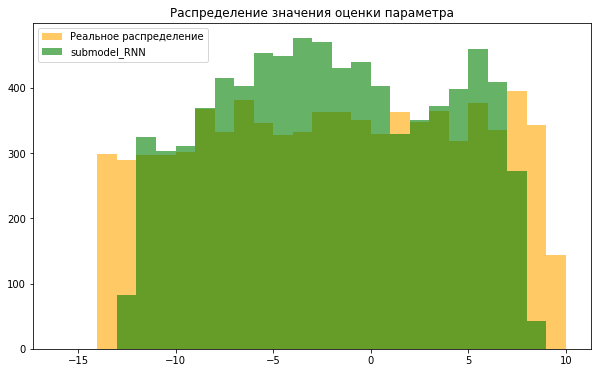

In [153]:
from matplotlib import pyplot as plt
plt_bins = [i + -16.001 for i in range(27)]
plt.figure(figsize=(10, 6))
plt.title("Распределение значения оценки параметра")
plt.hist(
    y_test,
    bins = plt_bins,
    alpha = 0.6,
    color = 'orange',
    label = 'Реальное распределение'
)
plt.hist(
    np.hstack(submodels_y_pred),
    bins = plt_bins,
    alpha = 0.6,
    color = 'green',
    label = 'submodel_RNN'
)
plt.legend()
plt.show()

In [154]:
model_big.model.save('/content/drive/MyDrive/rnn_april_23_lstm_big_2_impr.h5')
submodels[0].model.save('/content/drive/MyDrive/rnn_april_23_lstm_sub_{}_impr.h5'.format(0))
# for i in range(submodels_amount):
#     submodels[i].model.save('/content/drive/MyDrive/rnn_april_23_lstm_sub_{}.h5'.format(i))